### Python金融风控策略实战（基于Jupyter Notebook）
## <center>德国信贷风控数据建模（步骤1：数据清洗及预处理）</center>
### <center>策略制定及验证：张君颖  ； 报告日期：2020.11.3</center>
  <font color=blue><center>本报告不构成投资建议，转载需注明作者且不得删改</center></font>
  <font color=blue><center>作者邮箱：zhang.jun.ying@outlook.com</center></font>

### 第一步：导入需要使用的python库，并进行数据描述

In [2]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import missingno as msno
import warnings
warnings.filterwarnings("ignore") ## 忽略警告
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif']=['SimHei']   # 用黑体显示中文
matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号
matplotlib.rcParams['font.size']=15       

### 数据概况
数据来源：加州大学（UCI）欧文机器学习库    
http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29  

数据概况：“德国信用数据”将申请贷款的人分为“好信用”和“坏信用”，样本数据1000人，数据维度20维   

特征向量：1.支票账户状态；2.借款周期；3.历史信用；4.借款目的；5.信用额度；6.储蓄账户状态；7.当前就业状态；8.分期付款占可支配收入百分比；9.性别与婚姻状态；10.他人担保信息；11.现居住地；12.财产状态；13.年龄；14.其他分期情况；15.房产状态；16.信用卡数量；17.工作状态；18.赡养人数；19.电话号码注册情况；20.是否有海外工作经历

特征向量对应英文：1.status_account, 2.duration, 3.credit_history, 4,purpose, 5.amount, 6.svaing_account, 7.present_emp, 8.income_rate, 9.personal_status, 10.other_debtors, 11.residence_info, 12.property, 13.age, 14.inst_plans, 15.housing, 16.num_credits, 17.job, 18.dependents, 19.telephone, 20.foreign_worker    

输出结果：好信用（0），坏信用（1）   

数据收录时间：1994-11-17    

数据上传者：Professor Dr. Hans Hofmann 汉斯霍夫曼博士（德国汉堡大学）     

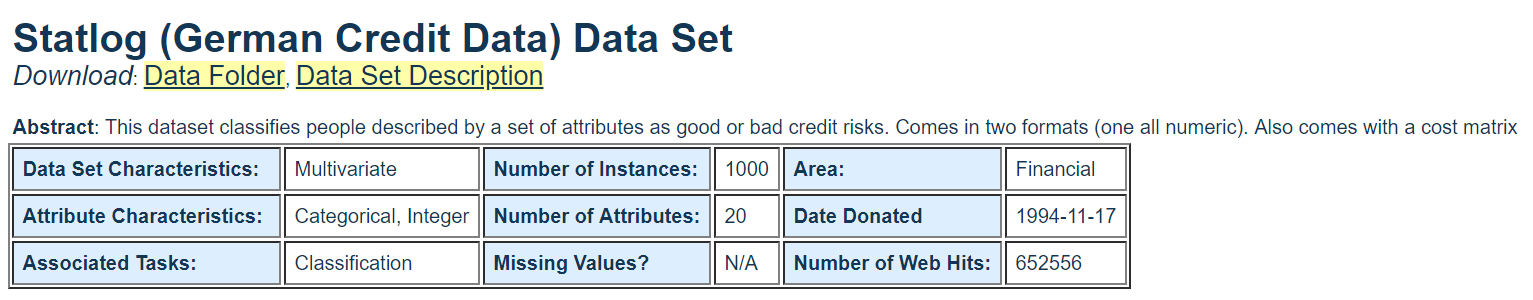

### 第二步：下载数据至本地，保存成csv格式，使用pandas导入数据

In [3]:
df = pd.read_csv('C:\\Users\\lotbear\\Desktop\\Data-science！\\金融风控实战数据\\german.csv',
                     delim_whitespace = True, header = None )
##变量重命名
columns = ['status_account','duration','credit_history','purpose', 'amount',
            'svaing_account', 'present_emp', 'income_rate', 'personal_status',
            'other_debtors', 'residence_info', 'property', 'age',
            'inst_plans', 'housing', 'num_credits',
            'job', 'dependents', 'telephone', 'foreign_worker', 'target']
df.columns = columns

##将标签变量由状态1,2转为0,1; 0表示好用户，1表示坏用户
df.target = df.target - 1

### 查看数据信息

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   status_account   1000 non-null   object
 1   duration         1000 non-null   int64 
 2   credit_history   1000 non-null   object
 3   purpose          1000 non-null   object
 4   amount           1000 non-null   int64 
 5   svaing_account   1000 non-null   object
 6   present_emp      1000 non-null   object
 7   income_rate      1000 non-null   int64 
 8   personal_status  1000 non-null   object
 9   other_debtors    1000 non-null   object
 10  residence_info   1000 non-null   int64 
 11  property         1000 non-null   object
 12  age              1000 non-null   int64 
 13  inst_plans       1000 non-null   object
 14  housing          1000 non-null   object
 15  num_credits      1000 non-null   int64 
 16  job              1000 non-null   object
 17  dependents       1000 non-null   i

### 数据的统计性描述

In [5]:
# 针对数值变量的描述性统计（int/float）
df.describe()

,duration,amount,income_rate,residence_info,age,num_credits,dependents,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,0.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000


### 第三步：区分离散变量与连续变量   
a. 先判断类型，如果是 int 或 float 就直接作为连续变量，否则为离散变量   
b. 将时间戳生成时间元组   

In [6]:
def category_continue_separation(df,feature_names):
    categorical_var = [] # 离散分类变量
    numerical_var = [] # 连续数值变量
    if 'target' in feature_names:
        feature_names.remove('target')
        ## 先判断类型，如果是int或float就直接作为连续变量
    numerical_var = list(df[feature_names].select_dtypes(include=['int','float','int32','float32','int64','float64']).columns.values)
    categorical_var = [x for x in feature_names if x not in numerical_var]
    return categorical_var,numerical_var

In [7]:
## 区分离散变量与连续变量
feature_names = list(df.columns)
feature_names.remove('target')
categorical_var,numerical_var = category_continue_separation(df,feature_names)
df.describe()

,duration,amount,income_rate,residence_info,age,num_credits,dependents,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,0.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000


### 第四步：数据清洗
a. 注入“脏数据”   
b. 变量status_account随机加入特殊字符   
c. 添加两列时间格式的数据   
d. 添加行冗余数据   
e. 数据清洗

In [8]:
def add_str(x):
    str_1 = ['%',' ','/t','$',';','@']
    str_2 = str_1[np.random.randint( 0,high = len(str_1)-1 )]
    return x+str_2

def add_time(num,style="%Y-%m-%d"):
    start_time = time.mktime((2010,1,1,0,0,0,0,0,0) )    
    stop_time = time.mktime((2015,1,1,0,0,0,0,0,0) )  
    re_time = []
    for i in range(num):
        rand_time = np.random.randint( start_time,stop_time)
        #将时间戳生成时间元组
        date_touple = time.localtime(rand_time)          
        re_time.append(time.strftime(style,date_touple)) #根据数据格式，将时间元组转换成字符串
    return re_time

def add_row(df_temp,num):
    index_1 = np.random.randint( low = 0,high = df_temp.shape[0]-1,size=num)
    return df_temp.loc[index_1]

In [9]:
##变量status_account随机加入特殊字符
df.status_account = df.status_account.apply(add_str)
##添加两列时间格式的数据
df['apply_time'] = add_time(df.shape[0],"%Y-%m-%d")
df['job_time'] = add_time(df.shape[0],"%Y/%m/%d %H:%M:%S")
##添加行冗余数据
df_temp = add_row(df,10)
df = pd.concat([df,df_temp],axis=0,ignore_index=True) # 根据相应的逻辑，将pandas对象连接在一个特定的轴上
df.shape

(1010, 23)

查看数据前5行

In [10]:
df.head()

,status_account,duration,credit_history,purpose,amount,svaing_account,present_emp,income_rate,personal_status,other_debtors,...,inst_plans,housing,num_credits,job,dependents,telephone,foreign_worker,target,apply_time,job_time
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A143,A152,2,A173,1,A192,A201,0,2012-07-17,2010/11/11 15:40:03
1,A12/t,48,A32,A43,5951,A61,A73,2,A92,A101,...,A143,A152,1,A173,1,A191,A201,1,2013-08-18,2014/10/09 02:16:04
2,A14%,12,A34,A46,2096,A61,A74,2,A93,A101,...,A143,A152,1,A172,2,A191,A201,0,2013-05-08,2011/11/14 16:55:52
3,A11/t,42,A32,A42,7882,A61,A74,2,A93,A103,...,A143,A153,1,A173,2,A191,A201,0,2014-09-27,2013/11/30 17:54:01
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A143,A153,2,A173,2,A191,A201,1,2014-07-07,2014/06/26 05:35:45


In [11]:
##设置显示多列
pd.set_option('display.max_columns', 10)
df.head()

,status_account,duration,credit_history,purpose,amount,...,telephone,foreign_worker,target,apply_time,job_time
0,A11,6,A34,A43,1169,...,A192,A201,0,2012-07-17,2010/11/11 15:40:03
1,A12/t,48,A32,A43,5951,...,A191,A201,1,2013-08-18,2014/10/09 02:16:04
2,A14%,12,A34,A46,2096,...,A191,A201,0,2013-05-08,2011/11/14 16:55:52
3,A11/t,42,A32,A42,7882,...,A191,A201,0,2014-09-27,2013/11/30 17:54:01
4,A11,24,A33,A40,4870,...,A191,A201,1,2014-07-07,2014/06/26 05:35:45


In [12]:
pd.set_option('display.max_columns',None)

### 举例查看离散变量范围

In [13]:
## 查看 status_account 离散变量范围
df.status_account.unique()

array(['A11 ', 'A12/t', 'A14%', 'A11/t', 'A14;', 'A12%', 'A12$', 'A12;',
       'A11;', 'A11$', 'A14/t', 'A14 ', 'A13;', 'A13$', 'A12 ', 'A13 ',
       'A11%', 'A14$', 'A13/t', 'A13%'], dtype=object)

### 举例特殊字符清洗

In [14]:
## 以 status_account 列数据进行特殊字符清洗
df.status_account = df.status_account.apply(lambda x:x.replace(' ','').replace('%','').
                             replace('/t','').replace('$','').replace('@','').replace(';',''))
df.status_account.unique()

array(['A11', 'A12', 'A14', 'A13'], dtype=object)

### 统一时间格式

In [15]:
## 统一为'%Y-%m-%d格式
df['job_time'] = df['job_time'].apply(lambda x:x.split(' ')[0].replace('/','-'))
##时间为字符串格式转为时间格式
df['job_time'] = df['job_time'].apply(lambda x:datetime.datetime.strptime( x, '%Y-%m-%d'))
df['apply_time'] = df['apply_time'].apply(lambda x:datetime.datetime.strptime( x, '%Y-%m-%d'))

### 样本去冗余

In [16]:
## 样本去冗余
df.drop_duplicates(subset=None,keep='first',inplace=True)
df.shape

(1000, 23)

In [17]:
## 可以按照订单去冗余
df['order_id'] = np.random.randint( low = 0,high = df.shape[0]-1,size=df.shape[0])
df.drop_duplicates(subset=['order_id'],keep='first',inplace=True)
df.shape

(642, 24)

In [18]:
## 如果有按列名去重复
#    df_1 = df.T # 对原数据进行转置
#    df_1 = df_1[~df_1.index.duplicated()] # 列名转置为索引数据，去重
#    df = df_1.T # 将去重的数据转置回来

### 查看连续型变量的统计性描述

In [19]:
df[numerical_var].describe()

,duration,amount,income_rate,residence_info,age,num_credits,dependents
count,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000,642.000000
mean,20.917445,3308.309969,2.965732,2.823988,35.311526,1.387850,1.152648
std,12.285516,2870.294069,1.123599,1.089670,11.095929,0.547901,0.359928
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1386.000000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2266.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,4042.000000,4.000000,4.000000,41.000000,2.000000,1.000000
max,60.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


### 添加缺失值

In [20]:
# 添加缺失值
df.reset_index(drop=True,inplace=True)
var_name = categorical_var+numerical_var
for i in var_name:
    num = np.random.randint( low = 0,high = df.shape[0]-1)
    index_1 = np.random.randint( low = 0,high = df.shape[0]-1,size=num)
    index_1 = np.unique(index_1)
    df[i].loc[index_1] = np.nan

### 缺失值绘图

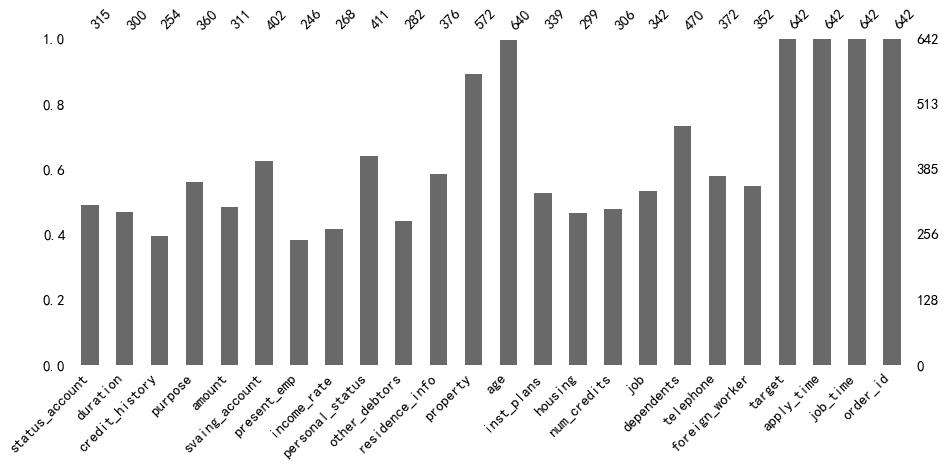

In [21]:
# 缺失值绘图
msno.bar(df, labels=True,figsize=(15,6), fontsize=15)

### 对于连续数据绘制箱线图，观察是否有异常值  

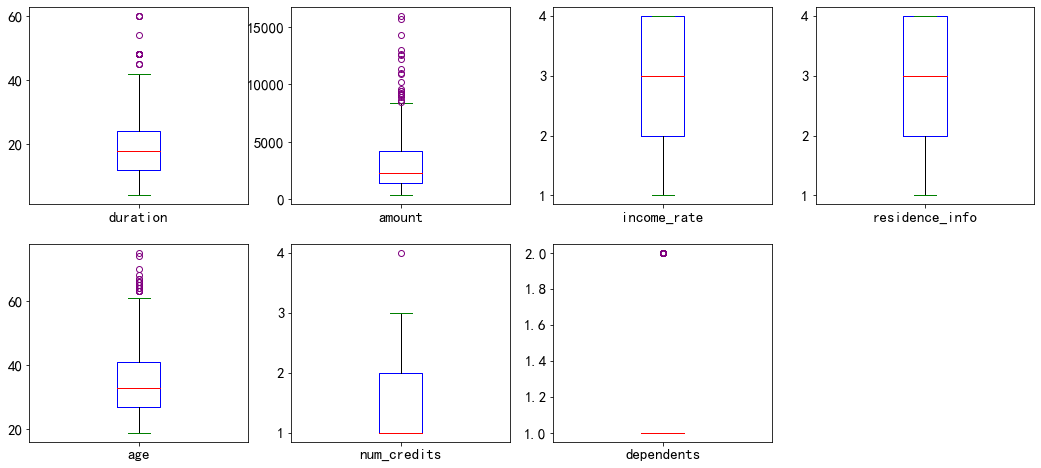

In [22]:
plt.figure(figsize=(18,8))    #设置图形尺寸大小
for j in range(1,len(numerical_var)+1):
    plt.subplot(2,4,j)
    df_temp = df[numerical_var[j-1]][~df[numerical_var[j-1]].isnull()]
    plt.boxplot( df_temp,
                notch=False,  #中位线处不设置凹陷
                widths=0.2,   #设置箱体宽度
                medianprops={'color':'red'},  #中位线设置为红色
                boxprops=dict(color="blue"),  #箱体边框设置为蓝色
                labels=[numerical_var[j-1]],  #设置标签
                whiskerprops = {'color': "black"}, #设置须的颜色，黑色
                capprops = {'color': "green"},      #设置箱线图顶端和末端横线的属性，颜色为绿色
                flierprops={'color':'purple','markeredgecolor':"purple"}#异常值属性，这里没有异常值，所以没表现出来
                   )
plt.show()

### 第五步：查看数据分布

分别绘制连续变量和离散变量的数据分布图

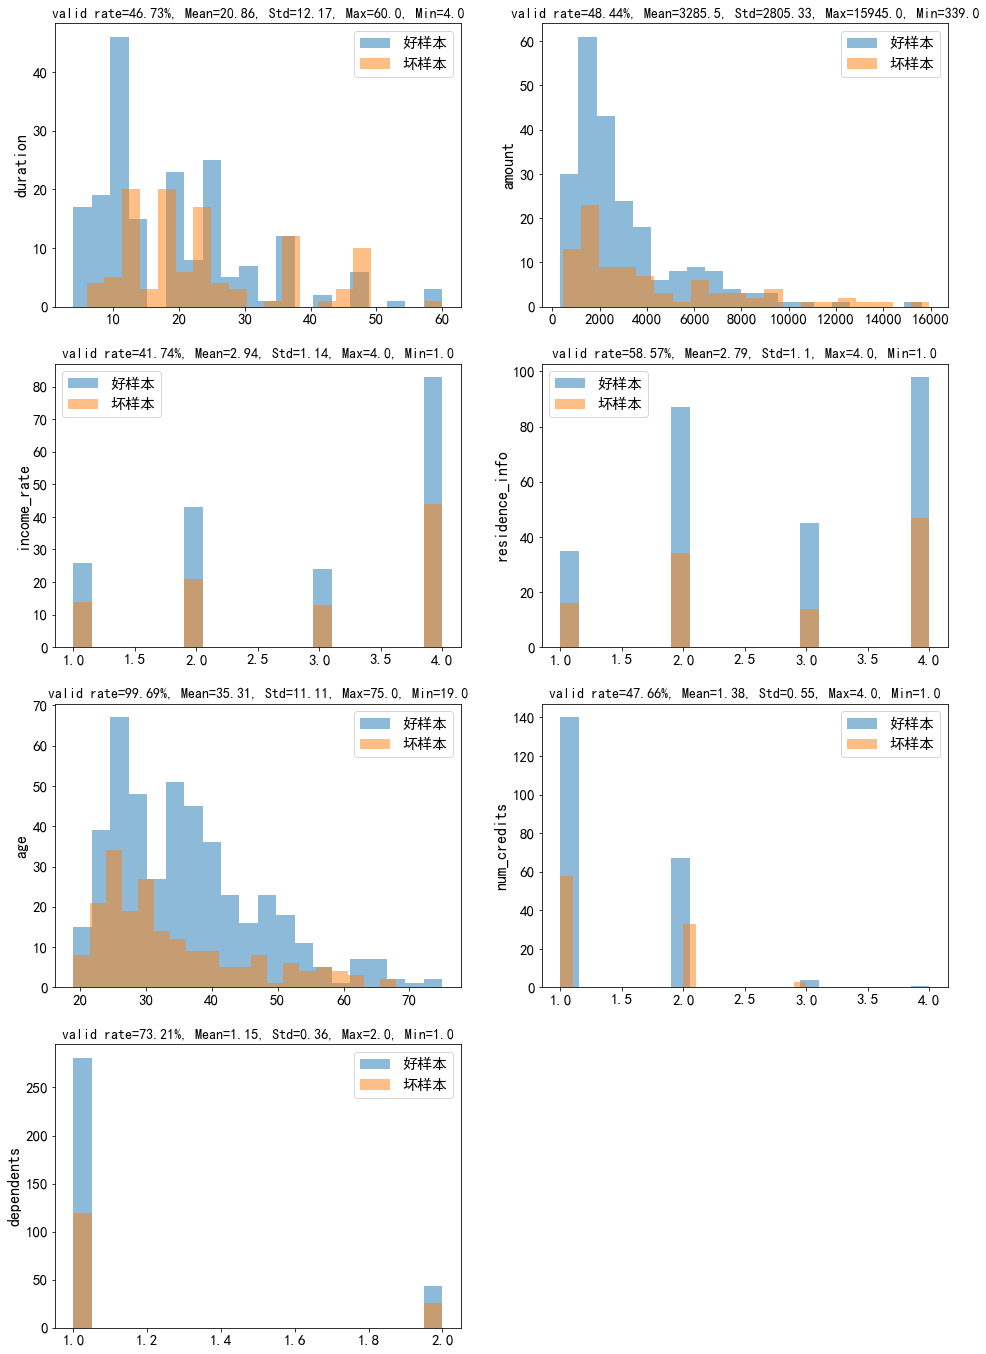

In [23]:
## 连续变量不同类别下的分布
j=1
plt.figure(figsize=(16,24)) 
for i in numerical_var:
    ##取非缺失值的数据
    df_temp = df.loc[~df[i].isnull(),[i,'target']]
    df_good = df_temp[df_temp.target == 0]
    df_bad = df_temp[df_temp.target == 1]
    ## 计算统计量
    valid = round(df_temp.shape[0]/df.shape[0]*100,2)
    Mean = round(df_temp[i].mean(),2)
    Std = round(df_temp[i].std(),2)
    Max = round(df_temp[i].max(),2)
    Min = round(df_temp[i].min(),2)
    ## 统计性描述绘图
    plt.subplot(4,2,j)
    plt.hist(df_good[i],bins =20, alpha=0.5,label='好样本')
    plt.hist(df_bad[i],bins =20, alpha=0.5,label='坏样本')
    plt.ylabel(i,fontsize=16)
    plt.title( 'valid rate='+str(valid)+'%, Mean='+str(Mean) + ', Std='+str(Std)+', Max='+str(Max)+', Min='+str(Min),fontsize=14)
    plt.legend(fontsize=15)
    j=j+1

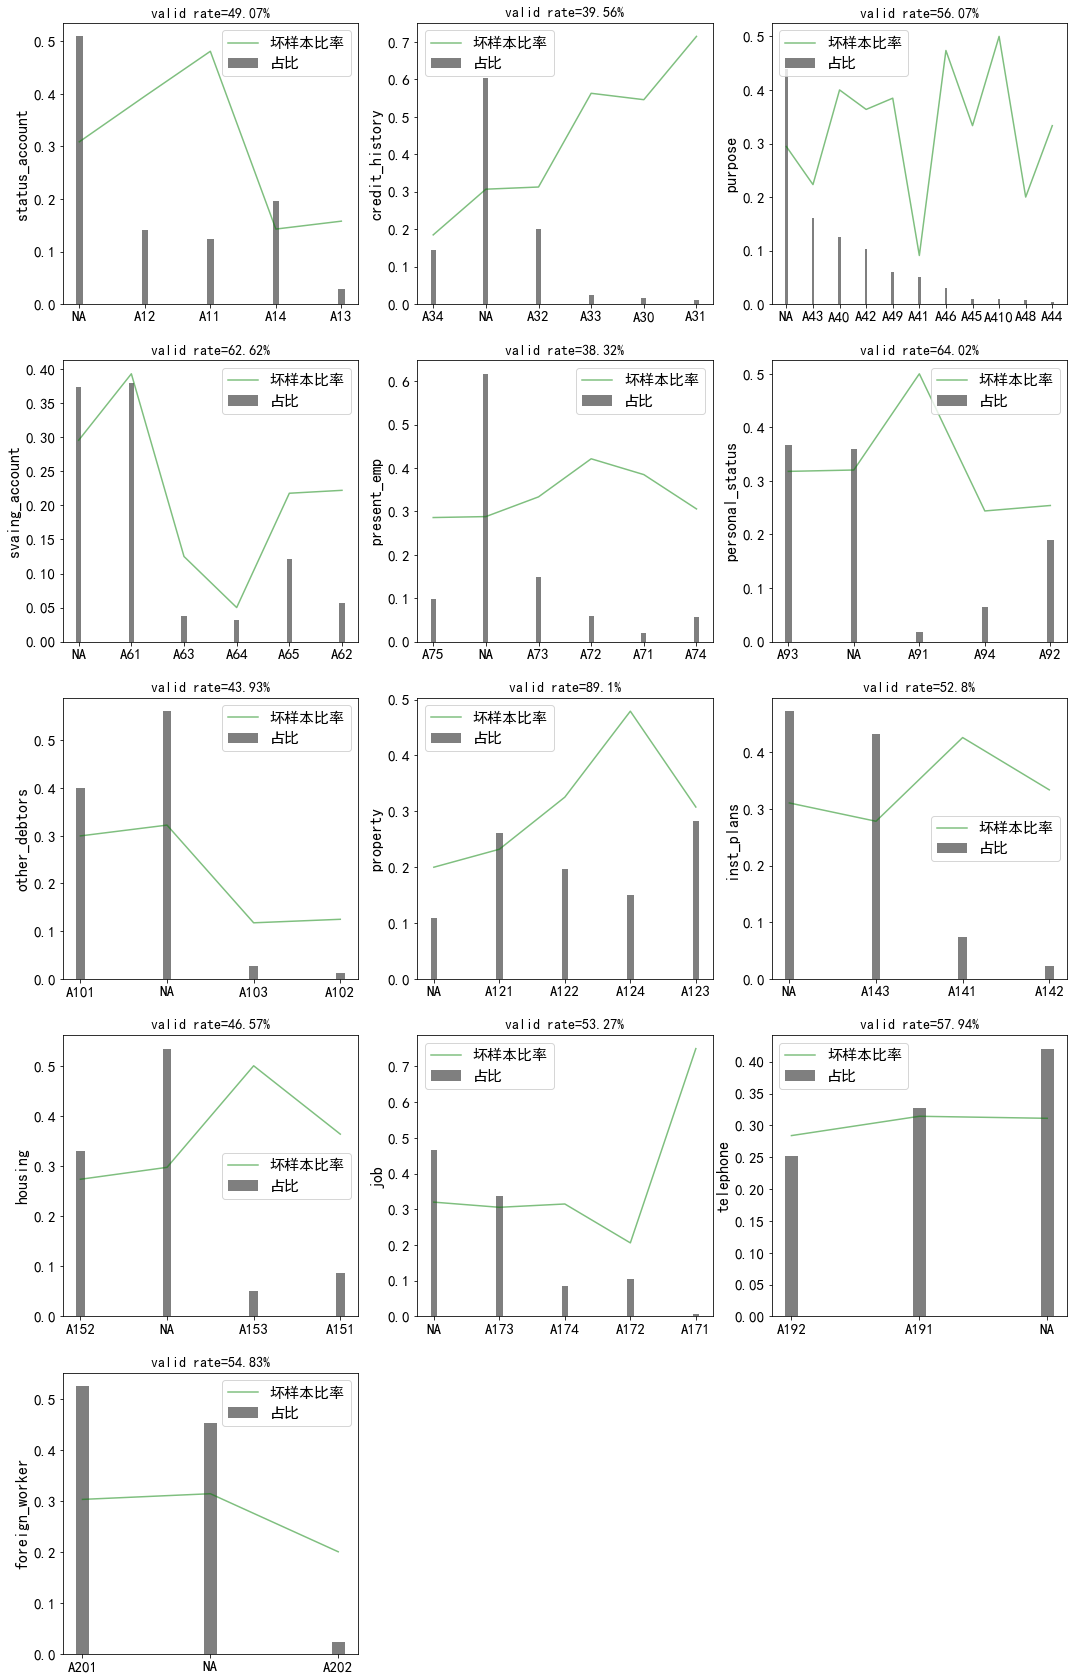

In [24]:
##离散变量不同类别下的分布
k=1
plt.figure(figsize=(18,30)) 
for i in categorical_var:
    ##非缺失值数据
    df_temp = df.loc[~df[i].isnull(),[i,'target']]
    df_bad = df_temp[df_temp.target == 1]
    valid = round(df_temp.shape[0]/df.shape[0]*100,2)
    bad_rate = []
    bin_rate = []
    var_name = []
    for j in df[i].unique():         
        if pd.isnull(j):
            df_1 = df[df[i].isnull()]
            bad_rate.append(sum(df_1.target)/df_1.shape[0])
            bin_rate.append(df_1.shape[0]/df.shape[0])
            var_name.append('NA')
        else:
            df_1 = df[df[i] == j]
            bad_rate.append(sum(df_1.target)/df_1.shape[0])
            bin_rate.append(df_1.shape[0]/df.shape[0])
            var_name.append(j)
    df_2 = pd.DataFrame({'var_name':var_name,'bin_rate':bin_rate,'bad_rate':bad_rate})
    ## 绘图
##离散变量不同类别下的分布
for i in categorical_var:
    ##非缺失值数据
    df_temp = df.loc[~df[i].isnull(),[i,'target']]
    df_bad = df_temp[df_temp.target == 1]
    valid = round(df_temp.shape[0]/df.shape[0]*100,2)
    bad_rate = []
    bin_rate = []
    var_name = []
    for j in df[i].unique():         
        if pd.isnull(j):
            df_1 = df[df[i].isnull()]
            bad_rate.append(sum(df_1.target)/df_1.shape[0])
            bin_rate.append(df_1.shape[0]/df.shape[0])
            var_name.append('NA')
        else:
            df_1 = df[df[i] == j]
            bad_rate.append(sum(df_1.target)/df_1.shape[0])
            bin_rate.append(df_1.shape[0]/df.shape[0])
            var_name.append(j)
    df_2 = pd.DataFrame({'var_name':var_name,'bin_rate':bin_rate,'bad_rate':bad_rate})
    ## 绘图
    plt.subplot(5,3,k)
    plt.bar(np.arange(1,df_2.shape[0]+1),df_2.bin_rate,0.1,color='black',alpha=0.5, label='占比')
    plt.xticks(np.arange(1,df_2.shape[0]+1), df_2.var_name)
    plt.plot( np.arange(1,df_2.shape[0]+1),df_2.bad_rate,  color='green', alpha=0.5,label='坏样本比率')   
    plt.ylabel(i,fontsize=16)
    plt.title( 'valid rate='+str(valid)+'%',fontsize=14)
    plt.legend(fontsize=15)
    k=k+1